## Scale Magnitude Transform for genre/rythmic pattern classification

In [23]:
%load_ext autoreload
%autoreload 2

import mirdata
import librosa
import helpers
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Groove Midi
*Jon Gillick, Adam Roberts, Jesse Engel, Douglas Eck, and David Bamman.
"Learning to Groove with Inverse Sequence Transformations."
  International Conference on Machine Learning (ICML), 2019.*
  
The Groove MIDI Dataset (GMD) is composed of 13.6 hours of aligned MIDI and (synthesized) audio of human-performed, tempo-aligned expressive drumming. The dataset contains 1,150 MIDI files and over 22,000 measures of drumming.

It could be used to classify fills or beats. Keep in mind that while fills tend to have a short duration (few seconds), beats tend to be longer. Therefore beats should be segmented in shorter chunks?


In [26]:
groove_dataset = mirdata.initialize("groove_midi")
# groove_dataset.download()
groove_dataset.validate()

100%|██████████| 1150/1150 [00:24<00:00, 46.52it/s] 
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


({'metadata': {}, 'tracks': {}}, {'metadata': {}, 'tracks': {}})

track.style -> a string style for the performance formatted as “primary/secondary” (e.g. rock/halftime, funk/purdieshuffle). The primary style comes from the Genre List below.

Genre List: afrobeat, afrocuban, blues, country, dance, funk, gospel, highlife, hiphop, jazz, latin, middleeastern, neworleans, pop, punk, reggae, rock, soul

For the following experiment the label will consist of the primary style only.

In [32]:
features = []
labels = []
for _, track in tqdm(groove_dataset.load_tracks().items()):
    if track.beat_type == "fill":
        try:
            y, sr = librosa.load(track.audio_path, sr=8000)
            stm = helpers.compute_stm(y=y, sr=sr)[:100]
            features.append(stm)
            labels.append(track.style.split("/")[0])
        except Exception as e:
            # exception encoutered with invalid audio_path
            print("Error:", e)
            continue

encoded_labels = LabelEncoder().fit_transform(labels)

  0%|          | 0/1150 [00:00<?, ?it/s]

100%|██████████| 1150/1150 [00:14<00:00, 77.45it/s]


Error: Invalid file: None


Cross-Validation Scores: [0.36923077 0.40310078 0.43410853 0.34883721 0.36434109]
Mean CV Accuracy: 0.38392367322599885


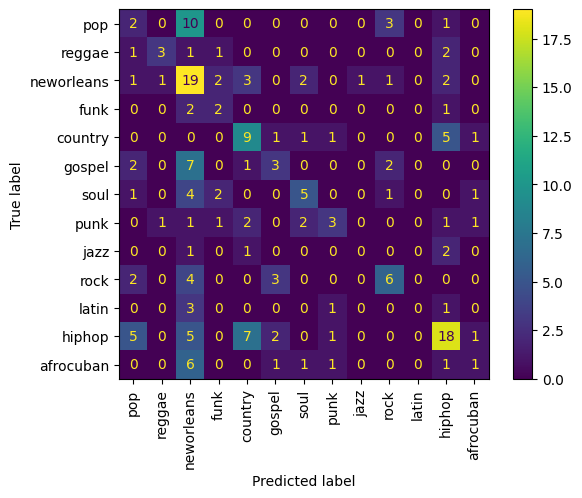

In [33]:
x_train, x_test, y_train, y_test = train_test_split(
    np.array(features), encoded_labels, test_size=0.3, stratify=encoded_labels, random_state=42
)

knn = KNeighborsClassifier(n_neighbors=3, metric="cosine")
# rnn = RadiusNeighborsClassifier(n_neighbors=7, metric="cosine").fit(X=X_train, y=y_train)

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn, features, encoded_labels, cv=k_fold, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

knn = KNeighborsClassifier(n_neighbors=7, metric="cosine").fit(X=x_train, y=y_train)
ConfusionMatrixDisplay.from_estimator(knn, x_test, y_test, display_labels=set(labels))
plt.xticks(rotation=90)  
plt.show()

## Ballroom


In [34]:
ballroom_dataset = mirdata.initialize("ballroom")
# ballroom_dataset.download()
ballroom_dataset.validate()

100%|██████████| 698/698 [00:09<00:00, 74.91it/s] 
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


({'tracks': {}}, {'tracks': {}})

In [35]:
features = []
labels = []
for _, track in tqdm(ballroom_dataset.load_tracks().items()):
    y, sr = librosa.load(track.audio_path, sr=8000)
    features.append(helpers.compute_stm(y=y, sr=sr)[:200])
    labels.append(track.genre)

encoded_labels = LabelEncoder().fit_transform(labels)

  0%|          | 0/698 [00:00<?, ?it/s]

100%|██████████| 698/698 [01:04<00:00, 10.88it/s]


Cross-Validation Scores: [0.77142857 0.75714286 0.69285714 0.71942446 0.82014388]
Mean CV Accuracy: 0.7521993833504625


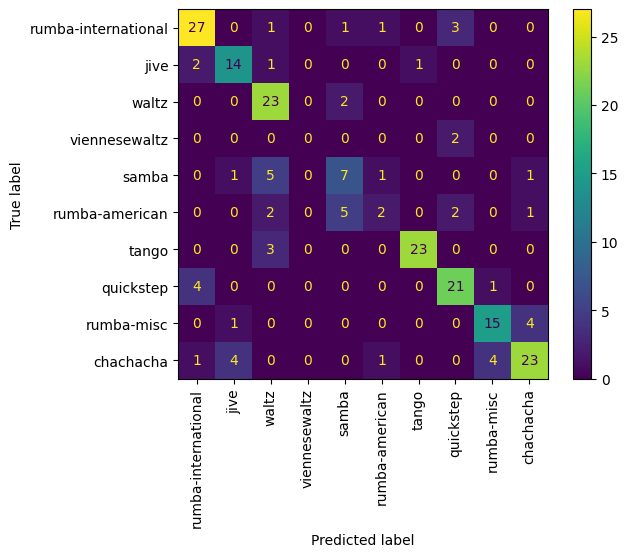

In [36]:
x_train, x_test, y_train, y_test = train_test_split(
    np.array(features), encoded_labels, test_size=0.3, stratify=encoded_labels, random_state=42
)

knn = KNeighborsClassifier(n_neighbors=7, metric="cosine")
# rnn = RadiusNeighborsClassifier(n_neighbors=7, metric="cosine").fit(X=X_train, y=y_train)

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn, features, labels, cv=k_fold, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

knn = KNeighborsClassifier(n_neighbors=7, metric="cosine").fit(X=x_train, y=y_train)

ConfusionMatrixDisplay.from_estimator(knn, x_test, y_test, display_labels=set(labels))
plt.xticks(rotation=90)  
plt.show()